# NFL Embeddings With CBOW

This notebook is an attempt at training word embeddings from the compiled Reddit NFL draft comments. The idea was to find out which word entities (players, teams, coaches, etc) we're used in similar context with each other-- they would then have similar embeddings.

I trained the embeddings using tranfer learning with Stanford's GloVe 50-dimensional vectors. Words in my corpus that were also in the GloVe corpus were intialized with the GloVe vectors, and the rest randomly. 

In [1]:
import numpy as np
import pandas as pd
import spacy
import string
import random
import re

from collections import defaultdict
from collections import Counter

In [279]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
# import pytorch libraries
%matplotlib inline
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

###### Load NFL Comments

In [3]:
r1 = pd.read_json('data/round1.json')
r2_3 = pd.read_json('data/round2_3.json')
r4_7 = pd.read_json('data/round4_7.json')
comments = pd.concat([r1, r2_3, r4_7])
comments.columns = ['Thread', 'User', 'Flair', 'Comment', 'Score', 'Awards', 'Time']

We replace hyperlinks and new line characters with empty strings.

In [4]:
comments.Comment = comments.Comment.str.replace(r'http\S+', '')
comments.Comment = comments.Comment.str.replace('\n', ' ')

###### Clean Text and Create Vocab

I used the Spacy library to tokenize the text. 'merge_entities' keeps entity strings together, instead of splitting on white space, e.g. 'joe burrow' rather than 'joe', 'burrow'.

I also clean the text by changing it all to lowercase, stripping whitespace and removing words with 1 character or less.

In [5]:
nlp = spacy.load("en_core_web_sm")

In [6]:
merge_ents = nlp.create_pipe("merge_entities")
nlp.add_pipe(merge_ents)

In [7]:
regex = re.compile('[^a-z ]')

In [8]:
def clean_text(row):
    text_list = [t.text.lower() for t in nlp(row)]
    text_list = [regex.sub('', w) for w in text_list]
    text_list = [text.strip() for text in text_list if len(text.strip()) > 1]
    return text_list

For the CBOW model, we only keep comments longer than 7 words/entities.

In [9]:
text = [clean_text(com) for com in comments.Comment.values]
text = [comment for comment in text if len(comment) >= 7]

In [303]:
text[0]

['that',
 'love',
 'pick',
 'was',
 'something',
 'else',
 'holy',
 'shit',
 'shockingly',
 'by',
 'the',
 'book',
 'for',
 'the',
 'first',
 'picks']

## CBOW

CBOW is a continuous-bag-of-words model, so we iterate through the text list and create all 7 word windows from each indiviual comment.

In [10]:
text_cbow = [seq[i-6:i+1] for seq in text for i in range(6, len(seq))]

In [11]:
text_cbow[:5]

[['that', 'love', 'pick', 'was', 'something', 'else', 'holy'],
 ['love', 'pick', 'was', 'something', 'else', 'holy', 'shit'],
 ['pick', 'was', 'something', 'else', 'holy', 'shit', 'shockingly'],
 ['was', 'something', 'else', 'holy', 'shit', 'shockingly', 'by'],
 ['something', 'else', 'holy', 'shit', 'shockingly', 'by', 'the']]

Split the dataset into 80% train and 20% validation.

In [12]:
random.shuffle(text_cbow)

In [13]:
idx = len(text_cbow)
train, val = text_cbow[:int(idx*0.80)], text_cbow[int(idx*0.80):]
len(train), len(val), idx

(493168, 123293, 616461)

Get all words in our training vocabulary. Delete rare words.

In [14]:
trn_vocab = [word for seq in train for word in seq]

In [15]:
word_ct = Counter(trn_vocab)
len(word_ct.keys())

29748

In [16]:
# Delete words that are very infrequent, < 10 instances
for word in list(word_ct):
    if word_ct[word] < 10:
        del word_ct[word]

In [17]:
len(word_ct.keys())

10518

Label encode each individual word, 'UNK' is for unknown words that may be in validation but not training.

In [18]:
# Label encode vocab words
vocab2idx = {'UNK': 0} # Intialize with unknown
words = ['UNK']
for word in word_ct:
    vocab2idx[word] = len(words)
    words.append(word)

In [19]:
def encode_seq(seq):
    return [vocab2idx.get(word, vocab2idx['UNK']) for word in seq]

In [20]:
train = [encode_seq(seq) for seq in train]
val = [encode_seq(seq) for seq in val]

The CBOW Dataset: Take the now label encoded windows of words, each has length 7. The middle word is the target y, and the context, words 1-3 and 4-6 are the inputs. We want to predict the target word from it's context.

In [21]:
class CBOWDataset(Dataset):
    def __init__(self, encoding):
        self.df = encoding

    def __len__(self):
        """ Length of the dataset """
        L = len(self.df)
        return L

    def __getitem__(self, idx):
        """ returns x[idx], y[idx] for this dataset
        
        x[idx] should be a numpy array of shape (6,)
        """
        x = self.df[idx][:3] + self.df[idx][4:]
        y = self.df[idx][3]
        return np.array(x), y 

In [22]:
train[:1]

[[1, 2, 3, 4, 5, 6, 7]]

In [23]:
dataset = CBOWDataset(train[:1])
x, y = dataset[0]
x, y

(array([1, 2, 3, 5, 6, 7]), 4)

In [24]:
V = len(vocab2idx.keys())
V

10519

##### Loading GloVe Vectors

We load the GloVe vectors from the text file and store in a dictionary with word: vec.

In [25]:
def loadGloveModel(gloveFile="data/glove.6B.50d.txt"):
    """ Loads word vectors into a dictionary."""
    f = open(gloveFile,'r')
    word_vecs = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        word_vecs[word] = np.array([float(val) for val in splitLine[1:]])
    return word_vecs

In [26]:
word_vecs = loadGloveModel()
len(word_vecs.keys())

400000

W will be our embedding matrix. We iterate through our training vocab and if the word has a GloVe vector, initialize it's index with the pre-trained vecor. Otherwise use a random vector.

In [27]:
W = np.zeros((V, 50), dtype="float32")
for word, idx in vocab2idx.items():
    if word == 'UNK':
        continue
    try:
        vec = word_vecs[word]
        W[idx] = vec
    except KeyError:
        W[idx] = np.random.uniform(-0.25, 0.25, 50)

In [28]:
W.shape

(10519, 50)

## Model

Architecture:

Input: x (length 6 vector, dim 1x6), y (index of target word, dim 1x1)

Lookup each embedding of our 6 context words (dim 6x50) and take the mean (dim 1x50).

Linear layer from dim 50 to dim V (len of training vocab).

In [52]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, emb_size, glove=None):
        super(CBOW, self).__init__()
        self.word_emb = nn.Embedding(vocab_size, emb_size)
        if glove is not None:
            self.word_emb.weight.data.copy_(torch.from_numpy(W))
            self.word_emb.weight.requires_grad = False ## freeze embeddings
            
        self.linear = nn.Linear(emb_size, vocab_size)
        
    def forward(self, x):
        x = self.word_emb(x)
        x = x.mean(axis=1)
        x = self.linear(x)
        return x

In [53]:
V = len(words)
emb = 10

model = CBOW(vocab_size=V, emb_size=emb)
small_dl = DataLoader(dataset, batch_size=2)
x, y = next(iter(small_dl))

In [54]:
out = model(x)
out.size()

torch.Size([1, 10519])

In [55]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [56]:
def val_metrics(model):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0
    for x, y in valid_dl:
        batch = y.shape[0]
        out = model(x.long())
        loss = F.cross_entropy(out, y)
        sum_loss += batch*(loss.item())
        total += batch
        pred = torch.max(out, dim=1)[1]
        correct += (pred == y).float().sum().item()
    val_loss = sum_loss/total
    val_acc = correct/total
    return val_loss, val_acc

In [57]:
def train_epocs(model, optimizer, epochs=10):
    prev_val_acc = 0
    for i in range(epochs):
        total_loss = 0
        total = 0
        model.train()
        for x, y in train_dl:
            y_hat = model(x.long())
            loss = F.cross_entropy(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += x.size(0)*loss.item()
            total += x.size(0)
        train_loss = total_loss/total
        val_loss, val_accuracy = val_metrics(model)
        
        print("train_loss %.3f val_loss %.3f val_accuracy %.3f" % (
            train_loss, val_loss, val_accuracy))
        
        #  save model
        if val_accuracy > prev_val_acc:
            prev_val_acc = val_accuracy
            path = "models/embedding_{0:.1f}.pth".format(100*val_accuracy) 
            if val_accuracy > 0.12:
                save_model(model, path)
                print(path)

In [58]:
def set_learning_rate(optimizer, lr):
    """Changing learning rates without creating a new optimizer"""
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [59]:
train_ds = CBOWDataset(train)
valid_ds = CBOWDataset(val)
train_dl = DataLoader(train_ds, batch_size=10000, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=10000)

###### Training

Train for 3 epocs with frozen embeddings. Just learning from initial GloVe vectors and random initialization.

In [60]:
model = CBOW(V, emb_size=50, glove=W)
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.025)

In [61]:
train_epocs(model, optimizer, epochs=3)

train_loss 6.783 val_loss 6.349 val_accuracy 0.055
train_loss 6.242 val_loss 6.252 val_accuracy 0.059
train_loss 6.136 val_loss 6.213 val_accuracy 0.061


Unfreeze embeddings and train more. We should see a decent size boost in accuracy intially.

In [62]:
# unfreezing the embeddings
model.word_emb.weight.requires_grad = True
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.025)

In [63]:
train_epocs(model, optimizer, epochs=5)

train_loss 5.861 val_loss 5.788 val_accuracy 0.109
train_loss 5.408 val_loss 5.658 val_accuracy 0.124
models/embedding_12.4.pth
train_loss 5.173 val_loss 5.623 val_accuracy 0.130
models/embedding_13.0.pth
train_loss 5.007 val_loss 5.623 val_accuracy 0.133
models/embedding_13.3.pth
train_loss 4.880 val_loss 5.647 val_accuracy 0.134
models/embedding_13.4.pth


In [64]:
set_learning_rate(optimizer, 0.01)

In [65]:
train_epocs(model, optimizer, epochs=3)

train_loss 4.717 val_loss 5.647 val_accuracy 0.135
models/embedding_13.5.pth
train_loss 4.673 val_loss 5.663 val_accuracy 0.135
models/embedding_13.5.pth
train_loss 4.637 val_loss 5.678 val_accuracy 0.135


## Analyze Vectors

In [66]:
from annoy import AnnoyIndex

In [67]:
W = model.word_emb.weight
W = W.detach().numpy()
W.shape

(10519, 50)

In [68]:
t = AnnoyIndex(50, "euclidean")
for i in range(W.shape[0]):
    t.add_item(i, W[i])
t.build(50) # 10 trees
t.save('W.ann')

True

In [69]:
t = AnnoyIndex(50, "euclidean")
t.load('W.ann')
t.get_nns_by_item(1, 4)

[1, 3161, 2366, 3821]

In [294]:
def gen_nns(w, t=t, k=5):
    ind = vocab2idx[w]
    return [words[x] for x in t.get_nns_by_item(ind, k)]

Nearest neighbors to a chosen vector.

In [295]:
gen_nns("tua")

['tua', 'jake fromm', 'burrow', 'jordan love', 'manlet']

In [296]:
gen_nns("rodgers")

['rodgers', 'aaron rodgers', 'brady', 'favre', 'mack']

In [297]:
gen_nns("aaron rodgers")

['aaron rodgers', 'aaron', 'jordan love', 'jerry jones', 'tee higgins']

In [298]:
gen_nns("hurts")

['hurts', 'reagor', 'next year', 'obviously', 'kerryon']

In [299]:
gen_nns("goodell")

['goodell', 'commish', 'bud light', 'gettleman', 'trey wingo']

In [300]:
gen_nns("andy reid")

['andy reid', 'jerry jones', 'dusted', 'mel kiper', 'rhule']

In [306]:
new = set(vocab2idx.keys()) - set(word_vecs.keys())
new_names = {item for item in new if item.count(' ') == 1}
new_names = {name for name in new_names if 'year' not in name 
                                        and 'the' not in name
                                        and 'day' not in name
                                        and 'night' not in name
                                        and 'minute' not in name
                                        and 'hour' not in name
                                        and 'season' not in name
                                        and 'a ' not in name
                                        and 'this' not in name
                                        and 'feeding' not in name
                                        and 'only one' not in name
                                        and 'draft' not in name}
len(new_names)

606

In [307]:
name_cts = [(name, word_ct[name]) for name in new_names]
names = sorted(name_cts, key=lambda x: x[1], reverse=True)[:50]
top_names = [nm for (nm, ct) in names]

In [280]:
emb_2d = TSNE(n_components=2, perplexity=45).fit_transform(W)
emb_2d.shape

(10519, 2)

In [308]:
idx = [vocab2idx[name] for name in top_names]

In [309]:
rev = {v:k for k,v in vocab2idx.items()}

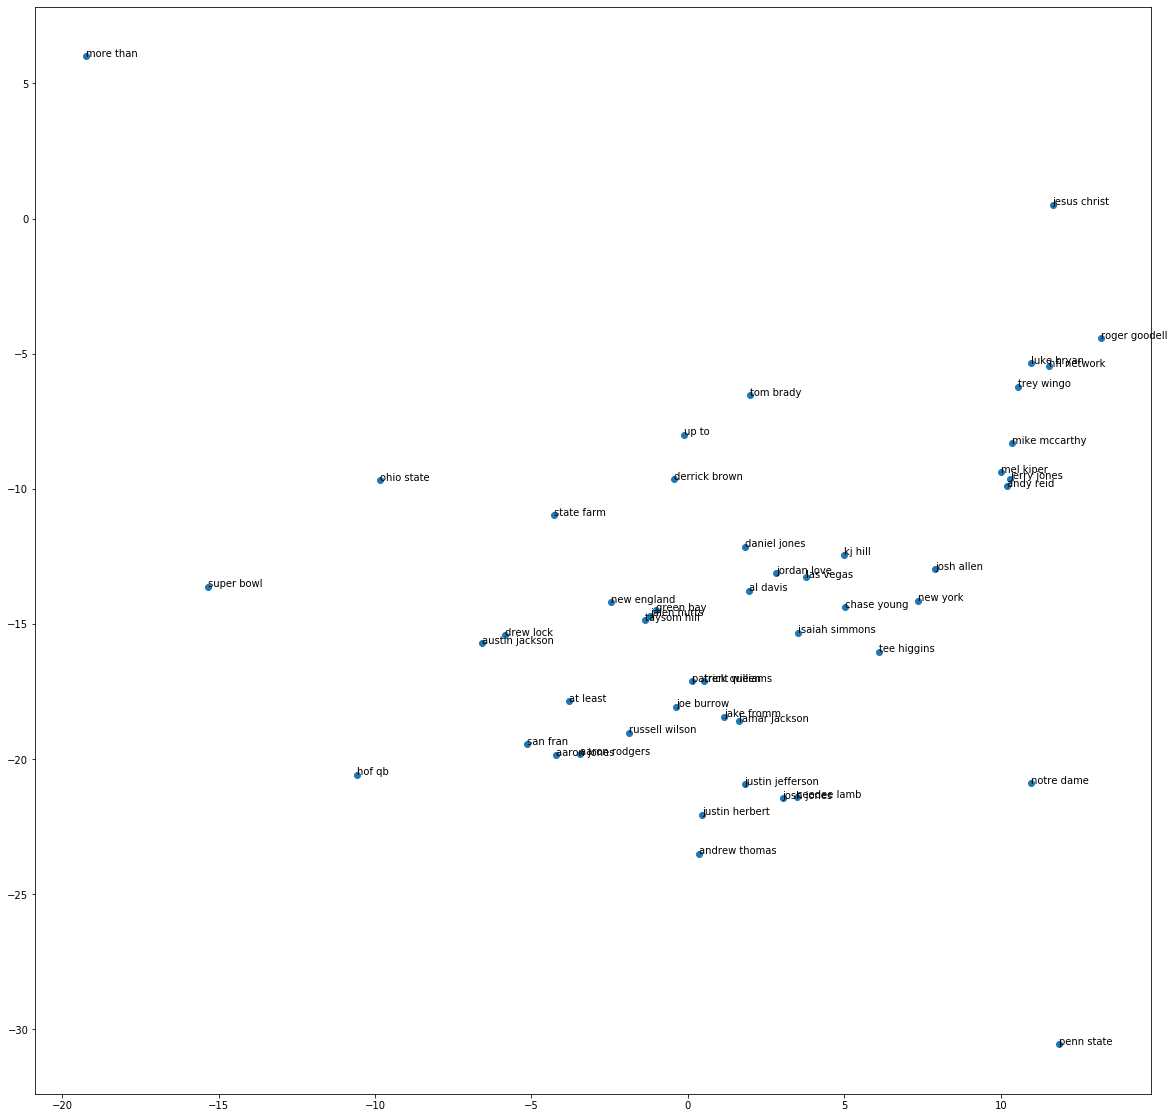

In [310]:
plt.figure(figsize=(20,20))
plt.scatter(emb_2d[idx,0], emb_2d[idx,1])

for i in idx:
    plt.annotate(rev[i], (emb_2d[i,0], emb_2d[i,1]))
    
plt.show()

#### Interesting Findings?

I plotted the top 50 most common 'new' words (not in GloVe) above.. Overall, there is not any clear pattern to the embeddings, but there are some interesting snippets that I will highlight. 

1. The clump of jerry jones, andy reid, mike mccarthy and mel kiper at (10, -10). The first 3 names are coaches of NFL teams and mel kiper is one of the prominent NFL draft analysts. The model clearly found that these names were used in similar context, and in a different context than draftees and current NFL players.

2. The clump of current and drafted NFL quarterbacks at (0, -20). This includes Russell Wilson, Aaron Rodgers, Joe Burrow, Jake Fromm and Lamar Jackson. Other quaterbacks are in the plot as well, but the model grouped these are similar. Aaron Rodgers is also right next to his starting running back, Aaron Jones.

3. Jalen Hurts and Taysom Hill are stacked together at (0, -15). Jalen Hurts in a dual-threat QB drafted to a team (Eagles) with an already established starting quarterback. Taysom Hill is a dual-threat QB already playing for a team (Saints) with an already established starting quarterback...

4. Things un-related, 'more than', 'jesus christ', 'penn state', are not near any NFL players. 